In [ ]:
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50, vgg16

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_from_disk

### Hyperparams

In [2]:
CNN = 'ResNet-50' # 'ResNet-50' or 'VGG-16'
#DATASET = 'CelebA_male_Smiling'
DATASET = 'CelebA_drift_simulated_with_Male_Wearing_Earrings'

NUM_CLASSES = 1      # Gender classification (1 for binary classification)

BATCH_SIZE = 128

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD
WEIGHT_DECAY = 5e-5  # Regularization

NUM_EPOCHS = 5      # Total number of training epochs
STEP_SIZE = 3       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 100

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset

In [3]:
dataset = load_from_disk(f"data/CelebA/{DATASET}")

num_train = dataset["historical_train"].num_rows
num_validation = dataset["historical_test"].num_rows
num_test = dataset["datastream_no_drift"].num_rows
num_test_drift = dataset["datastream_drift"].num_rows

In [4]:
print("Train split (historical_train):{}, \n"
      "Validation split (historical_test):{}, \n"
      "Test split (datastream_no_drift):{}, \n"
      "Test split (datastream_drift):{}".format(num_train, num_validation, num_test, num_test_drift))

Train split (historical_train):155951, 
Validation split (historical_test):19114, 
Test split (datastream_no_drift):19076, 
Test split (datastream_drift):1349


In [5]:
dataset

DatasetDict({
    historical_train: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 155951
    })
    historical_test: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebro

In [6]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = 1. if item['Male'] else 0.
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label

### Data processing

In [7]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(224),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image 224
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with ImageNet mean and standard deviation
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Data Loaders

In [8]:
# Datasets
train_dataset = HFDatasetWrapper(dataset['historical_train'], transform=train_transform)
val_dataset = HFDatasetWrapper(dataset['historical_test'], transform=eval_transform)
test_dataset = HFDatasetWrapper(dataset['datastream_no_drift'], transform=eval_transform)
test_dataset_drift = HFDatasetWrapper(dataset['datastream_drift'], transform=eval_transform)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

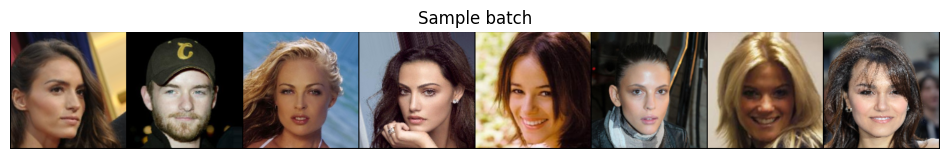

In [9]:
images, labels = next(iter(train_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.show()

### Model

In [10]:
if CNN == 'ResNet-50':
    net = resnet50() # Loading ResNet-50 model (pretrained on ImageNet)
    net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50
elif CNN == 'ResNet-50_pretrained':
    net = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT) # Loading ResNet-50 model (pretrained on ImageNet)
    net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50
elif CNN == 'VGG-16':
    net = vgg16() # Loading VGG-16 model (pretrained on ImageNet)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)  # Changed the last layer of VGG-16
elif CNN == 'VGG-16_pretrained':
    net = vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT) # Loading VGG-16 model (pretrained on ImageNet)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)  # Changed the last layer of VGG-16
else:
    net = None
    print("Unsupported model")

### Training

In [11]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

#parameters_to_optimize = net.features.parameters()
#parameters_to_optimize = net.classifier.parameters()
parameters_to_optimize = net.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [12]:
def plot_loss_accuracy_trend(loss_values, accuracy_values):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)

    epochs = np.arange(1, NUM_EPOCHS+1)

    plt.plot(epochs, loss_values[0], label="Training")
    plt.plot(epochs, loss_values[1], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, accuracy_values[0], label="Training")
    plt.plot(epochs, accuracy_values[1], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def get_accuracy(model, dataLoader):
    net = model.to(DEVICE)
    net.eval()

    with torch.no_grad():
        running_corrects = 0
        for images, labels in dataLoader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = net(images)
            # Get predictions
            #_, preds = torch.max(outputs.data, 1) # multi-class classification
            preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate and return Accuracy
    return running_corrects / (float(len(dataLoader.dataset)) - (len(train_dataloader.dataset) % BATCH_SIZE))

Starting epoch 1/5, LR = [0.01]
Step 0, Loss 0.6910029462742386
Step 100, Loss 0.6418091264204122
Step 200, Loss 0.5684330762892361
Step 300, Loss 0.37600293138530105
Step 400, Loss 0.3182440492673777
Step 500, Loss 0.32524679237894816
Step 600, Loss 0.22626130223397922
Step 700, Loss 0.14661614018677938
Step 800, Loss 0.14569859286325482
Step 900, Loss 0.14251566625443957
Step 1000, Loss 0.11548023178548306
Step 1100, Loss 0.08429298676044361
Step 1200, Loss 0.19666083636411713
Test Accuracy on Validation: 0.9474730563984514
Starting epoch 2/5, LR = [0.01]
Step 1300, Loss 0.08908444732317378
Step 1400, Loss 0.10463469013306792
Step 1500, Loss 0.08694927725269253
Step 1600, Loss 0.0901365177200475
Step 1700, Loss 0.14123994688951313
Step 1800, Loss 0.13127908785088493
Step 1900, Loss 0.06726640708577403
Step 2000, Loss 0.08825013098476298
Step 2100, Loss 0.11223647461545738
Step 2200, Loss 0.061531928227518407
Step 2300, Loss 0.09109368933334494
Step 2400, Loss 0.06093527860882375
Test

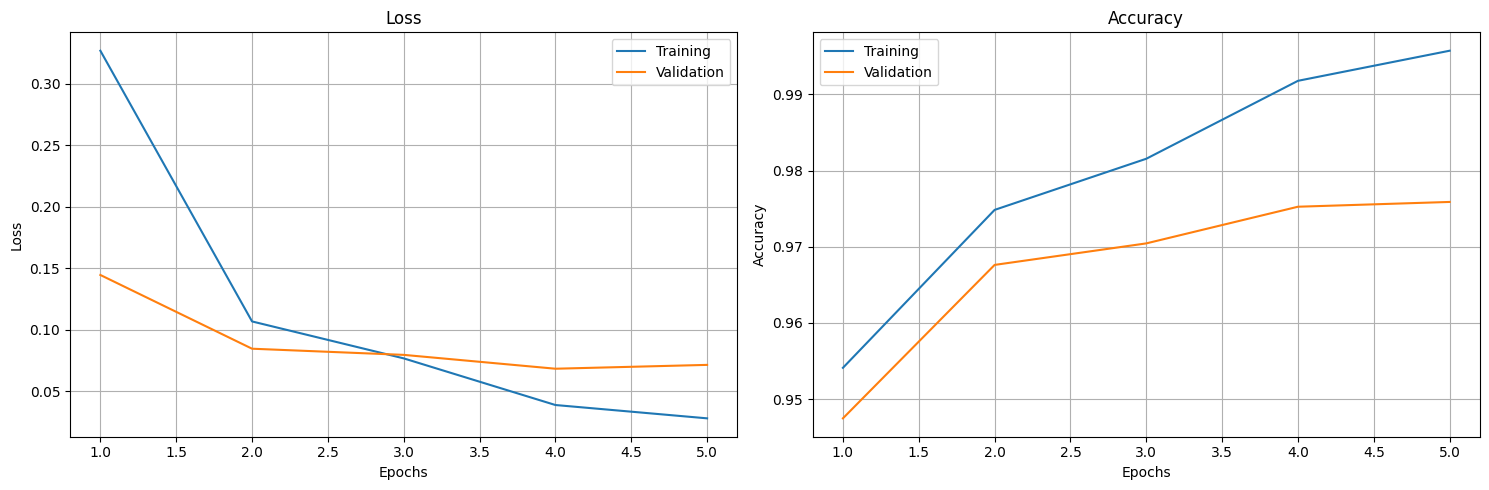

In [13]:
net = net.to(DEVICE)

best_net = None
best_accuracy = 0.0

train_acc = []
val_acc = []
train_loss = []
val_loss = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    running_loss = 0.0
    # Iterate over the dataset
    for images, labels in train_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode

        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs.squeeze(1), labels)
        running_loss += loss.item()

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    train_loss.append(running_loss / float(len(train_dataloader)))  # compute average loss
    train_acc.append(get_accuracy(net, train_dataloader)) # compute accuracy on train set

    # Evaluate the model on the validation set
    net = net.to(DEVICE)
    net.eval() # Set Network to evaluation mode

    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = net(images)

            # Compute loss based on output and ground truth
            loss = criterion(outputs.squeeze(1), labels)
            running_loss += loss.item()

            # Get predictions
            #_, preds = torch.max(outputs.data, 1) # multi-class classification
            preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('Test Accuracy on Validation: {}'.format(accuracy))

    # Update the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_net = copy.deepcopy(net)

    val_acc.append(accuracy)
    val_loss.append(running_loss / float(len(val_dataloader)))

    # Step the scheduler
    scheduler.step()

# Plot loss and accuracy trend
plot_loss_accuracy_trend([train_loss, val_loss], [train_acc, val_acc])

### Test (drift 0%)

In [14]:
best_net = best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(images)

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

100%|██████████| 150/150 [00:15<00:00,  9.43it/s]

Test Accuracy: 0.978873977773118
Best Accuracy on Validation: 0.975881552788532


### Test (drift 100%)

In [21]:
best_net = best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(test_dataloader_drift):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(images)

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset_drift))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

100%|██████████| 11/11 [00:01<00:00,  6.87it/s]

Test Accuracy: 0.8917716827279466
Best Accuracy on Validation: 0.975881552788532


### Save model

In [16]:
os.makedirs('./weights', exist_ok=True)
torch.save(best_net.state_dict(), f'./weights/{CNN}-{DATASET}.pth')

In [17]:
net.load_state_dict(torch.load(f'./weights/{CNN}-{DATASET}.pth', weights_only=True))
best_net = net